In [1]:
## Notebook env: brian_script_env (R kernel)

In [2]:
library(ggplot2)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(tidyverse)


path2 = '/khayyam/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q10_q90_original_luminalB_her2/'


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.4.0     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ dplyr::combine()    masks gridExtra::combine()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



In [3]:
## load patient metadata
meta = read.csv('/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_bcr_clinical_data_patient.txt', skip = 4, sep='\t')

## classify patients into subtypes
meta_luminal_A = meta %>% filter(ER_STATUS_BY_IHC == 'Positive' | PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Negative')
meta_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Positive')
meta_tnbc = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Negative')
meta_luminal_B_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Positive', PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Positive')

meta_luminal_A$PATIENT_ID = paste0(str_replace_all(meta_luminal_A$PATIENT_ID, '-', '.'), '.01')
meta_her2$PATIENT_ID = paste0(str_replace_all(meta_her2$PATIENT_ID, '-', '.'), '.01')
meta_tnbc$PATIENT_ID = paste0(str_replace_all(meta_tnbc$PATIENT_ID, '-', '.'), '.01')
meta_luminal_B_her2$PATIENT_ID = paste0(str_replace_all(meta_luminal_B_her2$PATIENT_ID, '-', '.'), '.01')

## Get patient subtype counts
paste('Luminal A patients:', nrow(meta_luminal_A))
paste('HER2+ patients:', nrow(meta_her2))
paste('Triple negative patients:', nrow(meta_tnbc))
paste('Luminal B with HER2+ patients:', nrow(meta_luminal_B_her2))

[1] "Luminal A patients: 445"

[1] "HER2+ patients: 37"

[1] "Triple negative patients: 116"

[1] "Luminal B with HER2+ patients: 100"

[1] FALSE

png 
  2

png 
  2

[1] 73.11994

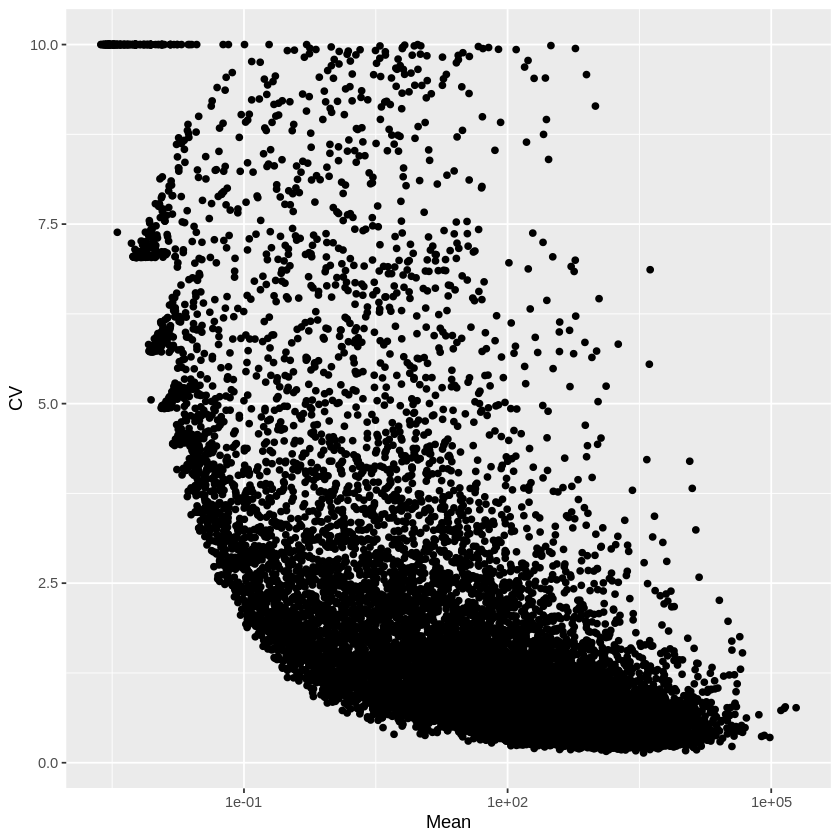

In [4]:
#' ---
#' title: "Analyzing BRCA TCGA data, FPKM data of **medium to high expressing** genes using Brian's script"
#' output: html_notebook
#' ---
#' 
#' This is modified version of Brian's q25 and q75 script: 'Analysis_heterogeneity_BRCA_TCGA_FPKM_approach_q25_q75.Rmd'
#' 
#' Let's create a mean vs CV graph for the patients to create a remove low expressing genes with high variability from our analysis
#' 
## ------------------------------------------------------------------------------



## load in data
RNA_Seq_expression_raw_data <- 
read.delim("/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_RNA_Seq_v2_expression_median.txt", stringsAsFactors = FALSE)

## subset breast cancer patients by type here
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data %>% select(any_of(c('Hugo_Symbol', 'Entrez_Gene_Id', meta_luminal_B_her2$PATIENT_ID))) %>% as.data.frame()

#The 'all' approach to check if all values in a row are 0
check_if_not_zero <- function (vector, number = 0) {
  if (!(all (vector == number))) {
    return (TRUE) #if not zero, then returns TRUE
  }
  else{
    return(FALSE)
  }
}

#See if there are any rows that are FALSE, meaning that are actually all 0
all(as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))) 
zero_genes = as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))

##take out genes with no expression in any of the patients
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data[as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero))),]


gene_medians = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, median)

median_df = data.frame(medians = gene_medians)

pdf(paste0(path2, 'gene_expression_pre_filter1.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 500) +
  geom_vline(xintercept = 10, color = 'blue') +
  theme_bw()
dev.off()

pdf(paste0(path2, 'gene_expression_pre_filter2.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 50000) +
  geom_vline(xintercept = 10, color = 'blue') + coord_cartesian(xlim = c(0,200)) +
  theme_bw()
dev.off()


pct_genes_left = function(median_expression, cutoff){
  pct = 100*length(which(median_expression >= cutoff))/length(median_expression)
  return(pct)
}

pct_genes_left(gene_medians, 10)

gene_means = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, mean)
gene_CVs = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, function(x){sd(x)/mean(x)})


gene_level_df = data.frame(Gene_name = RNA_Seq_expression_raw_data$Hugo_Symbol, Mean = gene_means, CV = gene_CVs)

ggplot(gene_level_df, aes(Mean, CV)) + geom_point() + scale_x_log10(breaks = log_breaks(5))


[1] 914

[1] 2463

[1] 576

[1] TRUE

[1] TRUE

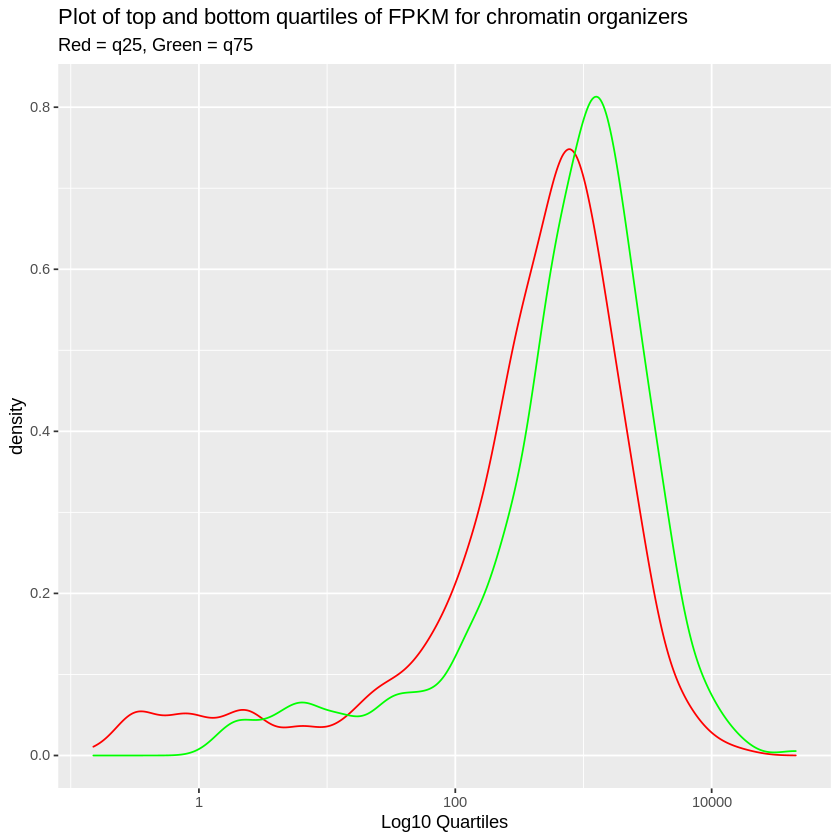

In [5]:
#' Copy and paste Brian's analysis from this point on
## ---- Data loading-------------------------------------------------------------

#Load in chromatin organization modifiers. How this was found: GO term, eukaryota => #mammalia => homo sapiens. Gives a list of gene products; there's non-unique entries #(contributed by different sources, etc)

chromatin_modifiers <- read.delim("/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/Chromatin_modifiers.txt", header=FALSE, stringsAsFactors=FALSE)

#the first column is the one of interest
colnames(chromatin_modifiers)[1] <- 'Gene Names'

chrom_list_to_sort_against <- unique(chromatin_modifiers$`Gene Names`)

#check lengths of new and original list from chromatin modifiers

length(chrom_list_to_sort_against) 
length(chromatin_modifiers$`Gene Names`)

#logic to extract the chromatin modifier genes specifically from the full RNA Seq list.
#Use the %in% operator to (vector-wise) get the rows specifically. Use this to get
#the quartiles for each gene:

set.seed(42)

chromatin_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% chrom_list_to_sort_against,]

#And these are the 'true' groupings. Let's add a column to denote that here, in front
#of the first two columns using the 'add_column' function from tibble library:

chromatin_genes_RNA_seq <- add_column(chromatin_genes_RNA_seq,
                                      Random = 'N', .after = 2)

length(rownames(chromatin_genes_RNA_seq))

#We'd like to also derive a background distribution for all of these genes. To do so,
#let's append 50 genes that are randomly selected from the dataset, and their #corresponding rows. 

random_genes <- sample(RNA_Seq_expression_raw_data$Hugo_Symbol, 50)
random_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% random_genes,]

random_names <- random_genes_RNA_seq$Hugo_Symbol

#Let's also add an equivalently named column here to denote that these are the random genes: 

random_genes_RNA_seq <- add_column(random_genes_RNA_seq, Random = 'Y', .after = 2)

full_genes_RNA_seq <- rbind(chromatin_genes_RNA_seq, random_genes_RNA_seq)

length(rownames(full_genes_RNA_seq)) == 
length(rownames(chromatin_genes_RNA_seq)) + length(rownames(random_genes_RNA_seq)) #TRUE

#creating a threshold with which to create 'hi' vs 'lo' populations of patients; here, I #choose to use top vs bottom quartile. Need to apply quantile across the rows of the #chromatin_genes data frame, excluding the first observation (which is a character string #of the gene name in question)

q25 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.25), na.rm = TRUE)

q75 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.75), na.rm = TRUE)


full_genes_RNA_seq <- add_column(full_genes_RNA_seq, q25 = q25, q75 = q75, .after = 3)

all (full_genes_RNA_seq$q25 <= full_genes_RNA_seq$q75) #true

#Also remove data where the bottom quartile is 0 FPKM. This doesn't seem like it would
#provide any meaningful data to a CV comparison.

full_genes_RNA_seq <- 
full_genes_RNA_seq[!(full_genes_RNA_seq$q25 == 0),]

#Viewing the data and indices

ggplot(full_genes_RNA_seq) + geom_density(aes (x = q25), color = 'red') +
geom_density (aes (x = q75), color = 'green') + 
labs (title = 'Plot of top and bottom quartiles of FPKM for chromatin organizers', 
      subtitle = 'Red = q25, Green = q75',
      x = 'Log10 Quartiles') + 
scale_x_log10()

In [6]:
#' ### Getting groupings of the data based on chromatin modifier expression
#' 
#' We've now completed some EDA of the data and cleaning of useless chromatin modifier factors that wouldn't be good for grouping. Now, let's get dataframes corresponding to these groupings in a list format to each unique chromatin modifier, then use these groupings to get subsetted dataframes from the full dataset corresponding to bottom/top expressers of each chromatin modifier.
#' 
## ---- Getting lo/hi groupings--------------------------------------------------

#Now I want lo and hi expressers (below q25, above q75) for each gene. Way to approach #this: create different groupings, based on hi/lo threshold. To first get the groupings #and return #them in a list: define a function that returns up to three entries in list #format. These are: Gene name, all names below the bottom quantile, and all names above #the top quantile.

groupings_returner <- function (gene, chromatin_data, gene_col = 1, random = 3, 
                                q25_col = 4, q75_col = 5) {
  #the q25_col, q75_col are last two columns in the data frame
  q25 = chromatin_data[chromatin_data[,gene_col]==gene, q25_col] 
  q75 = chromatin_data[chromatin_data[,gene_col]==gene, q75_col]
  rand_designation = chromatin_data[chromatin_data[,gene_col]==gene, random] 
  #get the q25, q75 'indices'
  row = chromatin_data[chromatin_data[,gene_col]==gene, c(-1:-2, -random, 
                                                          -q25_col, -q75_col)]
  #eliminate gene ID, the q25 and q75 columns; isolate a single row
  col = data.frame(t(row)) 
  #get into column format for easy use of row subsetting techniques
  colnames(col) = 'expression_levels'
  list_below_25 = rownames(col[col$expression_levels <= q25,, drop= FALSE]) 
  #to keep row names
  list_above_75 = rownames(col[col$expression_levels >= q75,, drop= FALSE])
  return (list(gene, rand_designation, list_below_25, list_above_75)) 
  #list of 3 entries. First = gene, second = bottom quartile, third = top quartile
}

#let's test that this function works as intended: make a 'test' vector that corresponds 
#to the ACTB gene, then compare this to the corresponding list in the full list.
#Note that the 1103 and 1104 columns correspond to the q25, q75 columns correspondingly.

test <- groupings_returner('HDAC2', full_genes_RNA_seq)

str(test) #should look like a 4 item list

#Some warnings will occur: this is because I sampled 50 randomly from the full dataset.
#Some overlapped with the list of chromatin modifiers list. This seems reasonable to 
#keep though.

groupings <- lapply(full_genes_RNA_seq$Hugo_Symbol, groupings_returner,                                       full_genes_RNA_seq)
str(groupings)

groupings[[2]][2] %in% test[3] #false

groupings[[1]][2] %in% test[2] #TRUE

#should have list of length equal to the chromatin gene list, with two or three entries #in each entry of the list

length(groupings) == length(full_genes_RNA_seq$Hugo_Symbol) 

#Now, using this list of groupings, I should then create dataframes corresponding to each
#groupings list, i.e. for below bottom quantile and above top quantile. This function #should take in a 'key' (each LIST entry within the groupings list) and return either #nothing, or two dataframes.

dataframe_returner <- function (key, full_data, additional_col_vectors = c(),
                                key_gene_entry = 1, key_random_entry = 2, 
                                key_25_entry = 3, key_75_entry = 4) {
    #additional_col_vectors fetches columns by name
  
    #Idea is to aggr. the columns that correspond to the 'correct' patients for each
    #quartile grouping
    q25_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_25_entry]])]
    #key_2/75_entry is a numeric index
    q75_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_75_entry]])]
    return (list(key[[key_gene_entry]], key[[key_random_entry]],
                 q25_dataframe, q75_dataframe))
}

#As a test: try this with the first gene entry from the above groupings data structure. #Expect: a three-entry list, with the first entry being the gene name, the second and #third being the corresponding data frames. Should have a dataframe with gene IDs, #followed by expression levels.

#use names in this vector to fetch columns corresponding to these two names
gene_vec <- c('Hugo_Symbol', 'Entrez_Gene_Id') 

#check that this list looks correct for a random gene, ACTL6A, index 1)
str(dataframe_returner(groupings[[1]], RNA_Seq_expression_raw_data, gene_vec)) 

#Code to actually get the grouped data
grouped_dataframes_list <- lapply(groupings, dataframe_returner, 
                                  RNA_Seq_expression_raw_data, gene_vec)

#' 
#' ### Appending CVs, CV ratios, to the grouped dataframe object
#' 
#' Let's now calculate CVs and the corresponding CV ratios for each gene between the bottom 
#' and top quartile groups. We will append these to the current grouped dataframes list object made in the previous code chunk. These will be used to determine whether a gene 
#' went up or down in its CV between lower and higher expression of the chromatin modifier in question.
#' 
## ---- Appending CVs------------------------------------------------------------
#First define a coefficient of variation function and apply across each row of the #dataframes in the grouped list:

coeff_variation <- function (vector) {
  return (sd(vector)/abs(mean(vector)))
}

#Calculate coefficient of variation for the entire grouped dataframes list.
#First define a helper function that takes in a list, and applies the given 
#function to the specified entries of the list (here, would like these entries to be the
#second and third entries). It then adds a new column corresponding to the values it 
#calculated. 

#omit the two first cols from being within the coeff_var calc, as they correspond to the #name/Gene ID for the gene in question

indices_omit <- -1:-2 

#This function operates at the level of a single dataframe. It takes in a dataframe and 
#returns a modified dataframe that has CV appended to the dataframe as a column. 

col_adjuster <- function (entry, omitted_indices = indices_omit, row_or_col = 1,
                          column_to_add_after = 2, col_name = 'CV',
                          f = coeff_variation, ...) {
  if (is.data.frame(entry)) {
    #has this is.data.frame entry so I can just simply apply this function across 
    #all of the list entries in the df_list that contain either df's or strings
      "... refers to the arguments of 'f'"
      col_result <- apply(entry[, omitted_indices], row_or_col, f, ...)
      #print(CV)
      entry <- add_column (entry, name = col_result, .after = column_to_add_after)
      colnames(entry)[colnames (entry) == 'name'] <- col_name 
      #adds the CV col (result of applying the function f) to original entry dataframe,
      #reassigning the name to match the name of the (statistic) calculated, e.g. CV, etc
  return (entry)
 #return the modified entry
  } else {
    return (entry)
  }
}

#Double apply call: nested lapply call works at the single list of dataframe level, 
#and the outer lapply call works to apply this across the entire grouped_dataframes_list
#object

grouped_dataframes_list_with_CV <- pblapply(grouped_dataframes_list, function (list) {
  lapply (list, col_adjuster) })

#Check that manually calculating CV gives the same result as this above call:

test_CV <- coeff_variation(as.numeric(grouped_dataframes_list[[2]][[3]][2,-1:-2]))

CV_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][2,]$CV

CV_not_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][50,]$CV

test_CV == CV_to_match #TRUE

test_CV == CV_not_to_match #FALSE
                                
#Now, take the ratios of the CV values. After doing this, then will have e.g. ~20440 #ratios. This function below works at the level of a 3-entry list, with one specified #entry in the list being a dataframe corresponding to bottom quantile, and vice versa for #top quantile.

CV_divider <- function (list, CV_index = 3, q25_entry = 3, q75_entry = 4) {
  #Calculate the CV ratio between q25 and q75 by dividing the two respective cols
  CV_ratio <- list[[q25_entry]][, CV_index]/list[[q75_entry]][, CV_index]
  
  list[[q25_entry]] <- add_column(list[[q25_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  #adds a CV_ratio column to the bottom quantile dataframe in the list
  list[[q75_entry]] <- add_column(list[[q75_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  return (list)
}

#See if this function works for just one entry in the full dataframe list (i.e. a 3-
#entry list)

test_CV_ratio <- CV_divider(grouped_dataframes_list_with_CV[[2]])

test_CV_ratio[[3]]$CV_ratio #should exist

grouped_dataframes_list_with_CV_ratio <- lapply(grouped_dataframes_list_with_CV, 
                                                CV_divider)

#Remove rows with NaN: define a function that removes all rows that are NaN for the 
#specified CV_ratio column (here, the 4th index). This meant that all of the rows
#were 0 for either the q25 grouping or q75 grouping, not unexpected (many genes 
#had high levels of 0's in the full dataset).

#!!Huge memory sink!! NEED TO FIX THIS. MEMORY VIRTUAL EXHAUSTED

#options (future.globals.maxSize = 4000 * 1024^5)

NaN_omitter <- function (entry, CV_ratio_col = 4) {
  if (is.data.frame(entry)) {
    return (entry[is.finite (entry[, CV_ratio_col]) ,])
  } else {
    return (entry)
  }
}

lapply_wrapper <- function (df_list, f) {
  return (lapply(df_list, f))
}

grouped_dataframes_list_with_CV_ratio_cleaned <- pblapply(grouped_dataframes_list_with_CV_ratio, lapply_wrapper, NaN_omitter)

#check that names match:
names_list <- lapply(grouped_dataframes_list, function (list) list[[1]])

names_CV_ratio <- lapply(grouped_dataframes_list_with_CV_ratio, function (list) 
  list[[1]])

names_CV_clean <- lapply(grouped_dataframes_list_with_CV_ratio_cleaned, function (list) 
  list[[1]])

identical(names_list, names_CV_ratio)

identical(names_list, names_CV_clean)

save(grouped_dataframes_list_with_CV_ratio_cleaned, file = paste0(path2, 'gped_clean_df_CV_ratio_q10_q90.RData'))

List of 4
 $ : chr "HDAC2"
 $ : chr "N"
 $ : chr [1:25] "TCGA.3C.AALI.01" "TCGA.A2.A04X.01" "TCGA.A8.A06T.01" "TCGA.A8.A07P.01" ...
 $ : chr [1:25] "TCGA.A2.A0YG.01" "TCGA.A8.A06U.01" "TCGA.A8.A075.01" "TCGA.A8.A07B.01" ...
List of 566
 $ :List of 4
  ..$ : chr "ACTL6A"
  ..$ : chr "N"
  ..$ : chr [1:25] "TCGA.A2.A04X.01" "TCGA.A8.A08H.01" "TCGA.AC.A23G.01" "TCGA.AC.A2FB.01" ...
  ..$ : chr [1:25] "TCGA.A2.A0YG.01" "TCGA.A8.A06U.01" "TCGA.A8.A08C.01" "TCGA.A8.A08P.01" ...
 $ :List of 4
  ..$ : chr "ACTR5"
  ..$ : chr "N"
  ..$ : chr [1:25] "TCGA.A1.A0SN.01" "TCGA.A8.A07B.01" "TCGA.A8.A08C.01" "TCGA.A8.A08H.01" ...
  ..$ : chr [1:25] "TCGA.A2.A04X.01" "TCGA.A2.A0YG.01" "TCGA.A7.A2KD.01" "TCGA.A8.A06U.01" ...
 $ :List of 4
  ..$ : chr "ACTR6"
  ..$ : chr "N"
  ..$ : chr [1:25] "TCGA.3C.AALI.01" "TCGA.3C.AALK.01" "TCGA.A2.A04X.01" "TCGA.A8.A08H.01" ...
  ..$ : chr [1:25] "TCGA.A7.A2KD.01" "TCGA.A8.A06T.01" "TCGA.A8.A06U.01" "TCGA.A8.A07P.01" ...
 $ :List of 4
  ..$ : chr "ACTR8"
  ..$ : c

[1] FALSE

[1] TRUE

[1] TRUE

List of 4
 $ : chr "ACTL6A"
 $ : chr "N"
 $ :'data.frame':	20026 obs. of  27 variables:
  ..$ Hugo_Symbol    : chr [1:20026] "LOC100130426" "UBE2Q2P3" "UBE2Q2P3" "LOC149767" ...
  ..$ Entrez_Gene_Id : int [1:20026] 100130426 100133144 100134869 10357 10431 155060 26823 280660 340602 388795 ...
  ..$ TCGA.A2.A04X.01: num [1:20026] 0 1.48 2.85 70.51 1451.2 ...
  ..$ TCGA.A8.A08H.01: num [1:20026] 0 2.55 4.58 135.42 922.6 ...
  ..$ TCGA.AC.A23G.01: num [1:20026] 0 1.02 5.52 82.86 675.15 ...
  ..$ TCGA.AC.A2FB.01: num [1:20026] 0 10.32 7.51 85.73 826 ...
  ..$ TCGA.AC.A3QQ.01: num [1:20026] 0 1.24 11.23 105.78 1187.53 ...
  ..$ TCGA.AC.A3TN.01: num [1:20026] 0 1.03 1.97 111.18 1062.99 ...
  ..$ TCGA.AC.A3YI.01: num [1:20026] 0 12.03 1.39 157.46 1001.59 ...
  ..$ TCGA.AC.A8OS.01: num [1:20026] 0 28.6 28.9 84.6 413.1 ...
  ..$ TCGA.AN.A03X.01: num [1:20026] 0 7.65 0 78.46 867.49 ...
  ..$ TCGA.AN.A0FN.01: num [1:20026] 0 0 2.7 131.8 999 ...
  ..$ TCGA.AO.A12C.01: num [1:20026] 0 16.4 19.1 55

[1] TRUE

[1] FALSE

[1]       NaN 0.9057925 1.5696600 1.1021447 0.6092233 0.7941703 1.0700593
    [8] 1.0000000 1.4137446 0.9006377 0.6737648 1.2048223 0.9323084       NaN
   [15] 1.0000000 1.4455373 1.2238680 1.0967704 0.8792353 1.1295984 1.0000000
   [22] 0.9053311 1.6298277 0.5444612 1.2417931 0.7773414 1.3391004 1.5059282
   [29] 0.7904725 1.8230807 4.9630246 0.9363504 1.9903413 1.5902194 0.6162320
   [36] 1.9562331 1.9075505 0.7216669 0.4237757 1.0000000 1.9091192 1.3995832
   [43] 0.8503711 0.9479725 0.8760296 1.1311025 0.8499724 0.9419497 1.6214600
   [50] 0.4080269 1.4619391 1.0814206 0.9127854 1.0180933 1.6857039 1.3792468
   [57] 0.9715647 1.2483803 0.6470187 0.8707239 1.5011920 0.8576382 1.1119203
   [64] 0.9106079 1.9862480 1.3514155 0.7223608 0.8451899 1.0170674 0.9277380
   [71] 0.9093613 1.7522179 0.9226903 0.8263143 1.2442248 1.0574010 0.9458161
   [78] 1.1194782 1.4124155 0.6562491 1.0096558 1.6030025 1.1660754 0.9973523
   [85] 1.0797381 1.5853798 1.1408006 0.7381552 0.5965322 0.7275321 1.3170750
   [92] 1.2748616 0.6363373 1.8670628 1.2185159 0.8602266 0.5265082 0.8198785
   [99] 0.7021303 0.3581733 1.1143230 1.3281318 1.0025851 0.6708100 0.7818180
  [106] 0.4924303 1.2925637 1.1883785 0.9745503 1.0450703 0.5919874 0.7223586
  [113] 1.1891835 1.0089402 1.0242089 0.9064581 0.5859115 0.8612984 1.0580665
  [120] 0.6081293 0.5529722 0.7789924 1.3028204 1.0899633 0.6994492 1.1262238
  [127] 1.0948613 0.6459864 0.7535357 2.0778646 1.0446852 0.4295230 1.6943849
  [134] 0.6473019 0.4529837 1.1319007 0.5689134 1.3269217 1.0428877 1.3586604
  [141] 0.9894105 0.9632661 1.0112881 0.7508025 0.9599953 0.9356386 1.5074684
  [148] 0.8714042 0.9356752 1.1607666 1.1152328 0.4140781 0.8635331 0.9219552
  [155] 1.8470909 0.9610707 0.7413171 0.6538239 0.6035766 0.5696139 1.0372222
  [162] 1.1025843 0.5360190 0.4901312 1.7419468 0.6933604 0.7429209 1.2482196
  [169] 1.7876158 1.4217322 0.8524195 1.2124772 1.5321019 0.9920234 0.8867327
  [176] 1.7896074 1.2547738 0.8242750 1.0214569 1.1229327 0.5816756 1.5122507
  [183] 0.6540842 1.0141435 0.6321376 1.0421417 1.4446534 0.6646660 1.1895921
  [190] 1.6689466 0.8233364 0.8402235 0.6707254 0.6729042 0.6630694 1.1414514
  [197] 1.9280252 1.3625844 0.9032087 0.8784463 0.9659628 1.1691778 1.0114930
  [204] 1.0466231 0.9301263 2.8346443 0.9076053 1.3027882 0.9424626 1.6188777
  [211] 0.6103626 1.7011054 1.8749261 1.0086364 1.6547057 0.6332104 1.3135921
  [218] 1.0526593 1.0970965 0.7415863 1.6314032 1.3264626 0.7340479 0.5838497
  [225] 0.8919793 0.8397587 1.3987737 0.5301451 0.7888048 0.9801180 0.5608391
  [232] 1.0000000 0.9280561 0.7663566 1.6325549 1.0000000 0.8024199 0.9846788
  [239] 0.1875890 1.0407513 1.4006824 0.8892688 0.6747955 0.6340730 1.0280820
  [246] 1.3321433 0.9735618 0.8406540 0.7489916 0.8303457 1.0001685       NaN
  [253] 0.9730994 1.5263985 1.0753446 1.1343884 0.9159683 1.6223944 0.8461060
  [260] 2.2776889 1.0739149 0.7455441 1.1170159 0.6965116 0.7187035 0.7714737
  [267] 1.4285949 1.2151953 0.6648681 0.6834214       NaN 1.0868403 0.9487070
  [274] 1.6781205 1.3762555 1.0559231 1.2028699 0.9678288 0.6252464 0.5106408
  [281] 0.6165287 0.4826286 0.5477398       NaN 1.3290279 0.4908839       NaN
  [288] 1.3891713 0.5986276 1.2092549 0.7641342 0.9806357 0.7138870 1.1875936
  [295] 0.8684522 1.6519541 1.3734501 0.6889508 1.0597294 1.3006254 1.4265242
  [302] 1.1764769 1.1306439 1.0164754 1.0197302 1.7028324 1.4137579 0.5312740
  [309] 2.0755596 4.3690049 1.4803993 0.9120755 1.5773124 1.0431352 0.9253648
  [316] 2.8164980 0.9043255 0.9801356 0.9449047 0.7323849 1.2219501 0.6133476
  [323] 1.3873408 0.7394212 0.9079771 0.6878688 0.8798075 0.5650487 1.7095223
  [330] 1.2642881 0.8733839 0.9350974 1.2954805 0.9187099 1.3585800 0.9994462
  [337] 0.7246891 1.3009258 0.8804228 0.7713620 0.8926124 1.1733779 0.8604787
  [344] 0.8577713 0.9732182 1.2203501 1.1938432 0.9470074 1.0025526 0.9790878
  [351] 1.0923164 0.7498646 1.1553284 0.9643356 1.2419112 0.7964693 0.3225124
  [358] 1.0648201 2.453438

[1] TRUE

[1] TRUE